In [13]:
import numpy as np

# module for computing a Conditional Frequency Distribution
from nltk.probability import ConditionalFreqDist

# module for computing a Conditional Probability Distribution
from nltk.probability import ConditionalProbDist

# module for computing a probability distribution with the Maximum Likelihood Estimate
from nltk.probability import LaplaceProbDist

# for calculating KL divergence
from scipy.stats import entropy

# for clustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [7]:
# this is just for testing data
from nltk.corpus import brown

tagged_sentences = brown.tagged_sents(categories= 'news')

tagged_sentences_list  = []
for i in range(10):
    tagged_sentences_list.append(tagged_sentences[i*100:(i+1)*100])


In [8]:
## convert the tagged sentences into conditional probability distributions

num_languages = len(tagged_sentences_list)

transition_PD_list = []
for tagged_sentences in tagged_sentences_list: 
    # the data object should be an array of tuples of conditions and observations
    # in our case the tuples will be of the form (tag_(i),tag_(i+1))
    data_by_sent = [[(sentence[i][1], sentence[i+1][1]) for i in range(len(sentence) - 1)] for sentence in tagged_sentences]
    data = [tup for sentence in data_by_sent for tup in sentence]

    # compute the Conditional Frequency Distribution for a tag given the previous tag
    transition_FD = ConditionalFreqDist(data)

    # compute the Conditional Probability Distribution for the
    # transition probability P(tag_(i+1)|tag_(i)) using the MLEProbDist
    # to estimate the probabilities
    transition_PD = ConditionalProbDist(transition_FD, LaplaceProbDist)

    transition_PD_list.append(transition_PD)

# get a list of common POS tags
pos_set = set(transition_PD_list[0].conditions())
for transition_PD in transition_PD_list:
    pos_set = pos_set.intersection(set(transition_PD))

pos_list = list(pos_set)

In [9]:
## function for getting probabilitity distributions as a matrix
## this should be less hard than it is, seriously
def conditional_PD_to_matrix(conditional_PD):
    prob_matrix = np.zeros(shape=(len(pos_list), len(pos_list)))
    for index, pos_condition in enumerate(pos_list):
        prob_dist = [conditional_PD[pos_condition].prob(pos) for pos in pos_list]
        prob_matrix[index] = prob_dist
    return prob_matrix

## function for distance between two conditional prob dist
def KL_divergence(prob_matrix_1, prob_matrix_2):
    total_entropy = 0
    for row1, row2 in zip(prob_matrix_1, prob_matrix_2):
        total_entropy += entropy(row1, row2)
    return total_entropy 

def frobenius_norm(prob_matrix_1, prob_matrix_2):
    return np.linalg.norm(prob_matrix_1 - prob_matrix_2) #Frobenius norm

In [19]:
# convert list of PD to list of matrices
probdist_matrices = [conditional_PD_to_matrix(PD) for PD in transition_PD_list]

# create similarity matrix
dist_matrix = np.zeros(shape=(num_languages, num_languages))
for i in range(num_languages):
    for j in range(i+1, num_languages):
        dist_matrix[i][j] = KL_divergence(probdist_matrices[i], probdist_matrices[j])
dist_matrix = dist_matrix + dist_matrix.T

/var/folders/nc/c4sy2sx128xbn1pnq3183yj40000gn/T/ipykernel_17683/688341326.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dist_matrix, "complete")


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [65.0, 65.0, 75.0, 75.0],
  [85.0, 85.0, 95.0, 95.0],
  [70.0, 70.0, 90.0, 90.0],
  [55.0, 55.0, 80.0, 80.0],
  [40.0, 40.0, 67.5, 67.5],
  [25.0, 25.0, 53.75, 53.75],
  [10.0, 10.0, 39.375, 39.375]],
 'dcoord': [[0.0, 7.356198872113362, 7.356198872113362, 0.0],
  [0.0, 6.2608475409239395, 6.2608475409239395, 0.0],
  [0.0, 5.205580083055815, 5.205580083055815, 0.0],
  [0.0, 5.977097563585328, 5.977097563585328, 0.0],
  [5.205580083055815, 6.183262891303822, 6.183262891303822, 5.977097563585328],
  [0.0, 6.755749880676404, 6.755749880676404, 6.183262891303822],
  [6.2608475409239395,
   7.504739522085525,
   7.504739522085525,
   6.755749880676404],
  [0.0, 7.944408471399743, 7.944408471399743, 7.504739522085525],
  [7.356198872113362,
   9.044295027133192,
   9.044295027133192,
   7.944408471399743]],
 'ivl': ['3', '7', '2', '0', '4', '9', '1', '8', '5', '6'],
 'leaves': [3, 7, 2, 0, 4, 9, 1, 8, 5, 6],
 'color_list': ['C

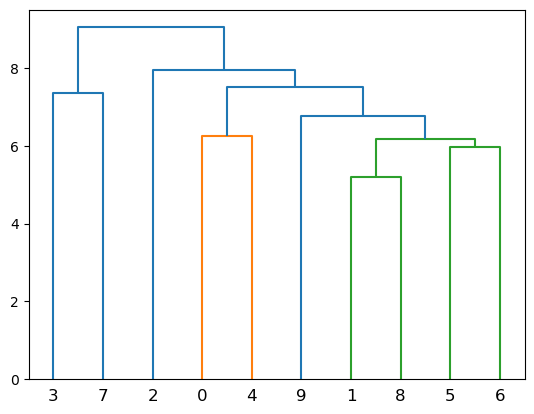

In [20]:
# cluster!

linkage_matrix = linkage(dist_matrix, "complete")
dendrogram(linkage_matrix)
